# Predict Future Sales

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, metrics

## Data 확인

In [2]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

In [3]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [4]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [7]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [9]:
print('train shape : ', train.shape)
print('test shape : ', test.shape)
print('items shape : ', items.shape)
print('shops shape : ', shops.shape)
print('cats shape : ', cats.shape)

train shape :  (2935849, 6)
test shape :  (214200, 3)
items shape :  (22170, 3)
shops shape :  (60, 2)
cats shape :  (84, 2)


# Data 전처리

In [10]:
# 중복 체크
sum(train.duplicated()), sum(test.duplicated()),sum(items.duplicated()), sum(cats.duplicated()), sum(shops.duplicated())

(6, 0, 0, 0, 0)

In [11]:
train[train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [12]:
# 중복 제거
train.drop_duplicates(inplace=True)

In [13]:
# 중복 재확인
sum(train.duplicated())

0

In [14]:
#테스트에만 있는 상품
test_only = set(test['item_id'].unique()) - set(train['item_id'].unique())
print('test only items:', len(test_only))

test only items: 363


In [15]:
#테스트 데이터에 없는 샵 및 아이템 드롭 
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

print('train:', train.shape)

train: (1224434, 6)


In [16]:
#결측치
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [17]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

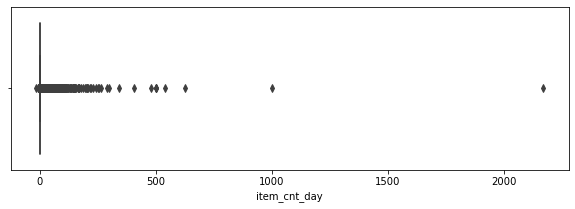

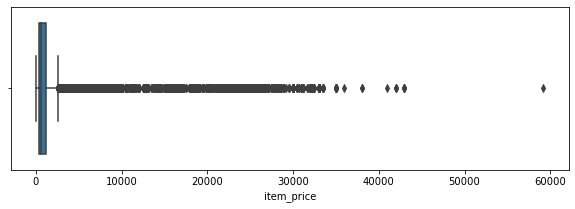

In [18]:
#이상치 제거
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=train);

In [19]:
train = train[train.item_cnt_day < 500]
train = train[train.item_price < 50000]

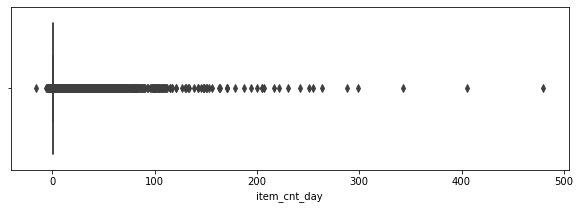

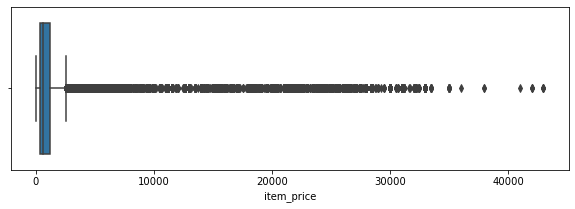

In [20]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=train);

In [21]:
train = train[train.item_cnt_day < 300]
train = train[train.item_price < 40000]

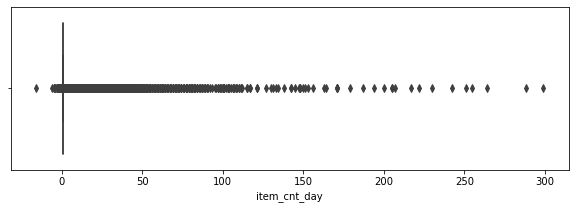

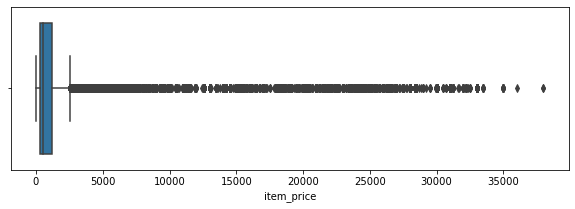

In [22]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=train);

In [23]:
#가격 < 0 -> 중앙값으로 채우기
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

<AxesSubplot:xlabel='item_cnt_day'>

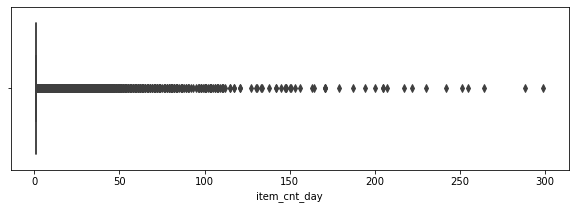

In [24]:
#item_cnt_day 0보다 작은 값 제거
train=train[train.item_cnt_day>0]
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day',data=train)

In [25]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,1.221474e+06,1.221474e+06,1.221474e+06,1.221474e+06,1.221474e+06
mean,1.935384e+01,3.215242e+01,9.618610e+03,1.028921e+03,1.321127e+00
std,9.110795e+00,1.646377e+01,6.300608e+03,1.821104e+03,2.177922e+00
min,0.000000e+00,2.000000e+00,3.000000e+01,5.000000e-01,1.000000e+00
25%,1.200000e+01,1.900000e+01,4.181000e+03,2.990000e+02,1.000000e+00
50%,2.100000e+01,3.100000e+01,7.856000e+03,5.490000e+02,1.000000e+00
75%,2.700000e+01,4.600000e+01,1.523700e+04,1.199000e+03,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,3.799100e+04,2.990000e+02


## 시각화

C:\Users\janyq\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


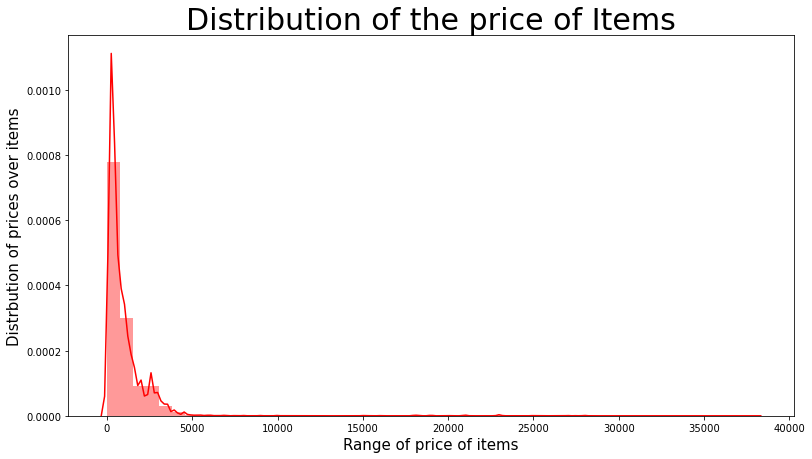

In [26]:
plt.rcParams['figure.figsize'] = (13, 7)
sns.distplot(train['item_price'], color = 'red')
plt.title('Distribution of the price of Items', fontsize = 30)
plt.xlabel('Range of price of items', fontsize = 15)
plt.ylabel('Distrbution of prices over items', fontsize = 15)
plt.show()

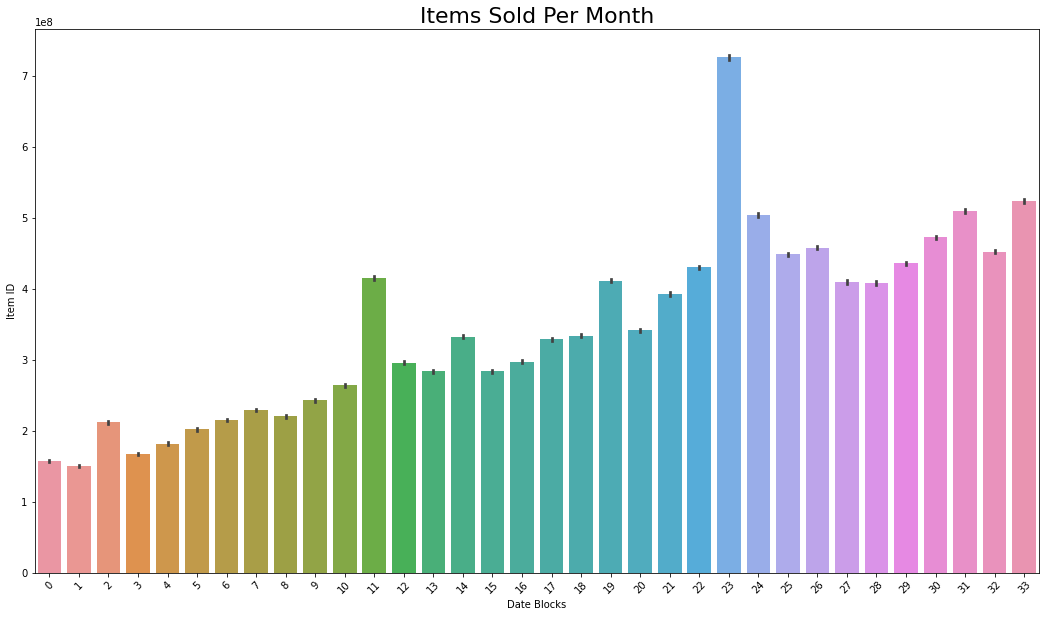

In [27]:
plt.figure(figsize = (18,10))
plt.title('Items Sold Per Month', fontsize=22)
ax = sns.barplot(x='date_block_num', y="item_id", data=train, estimator=np.sum)
ax = ax.set(xlabel='Date Blocks', ylabel='Item ID')
plt.xticks(rotation=45)
plt.show()

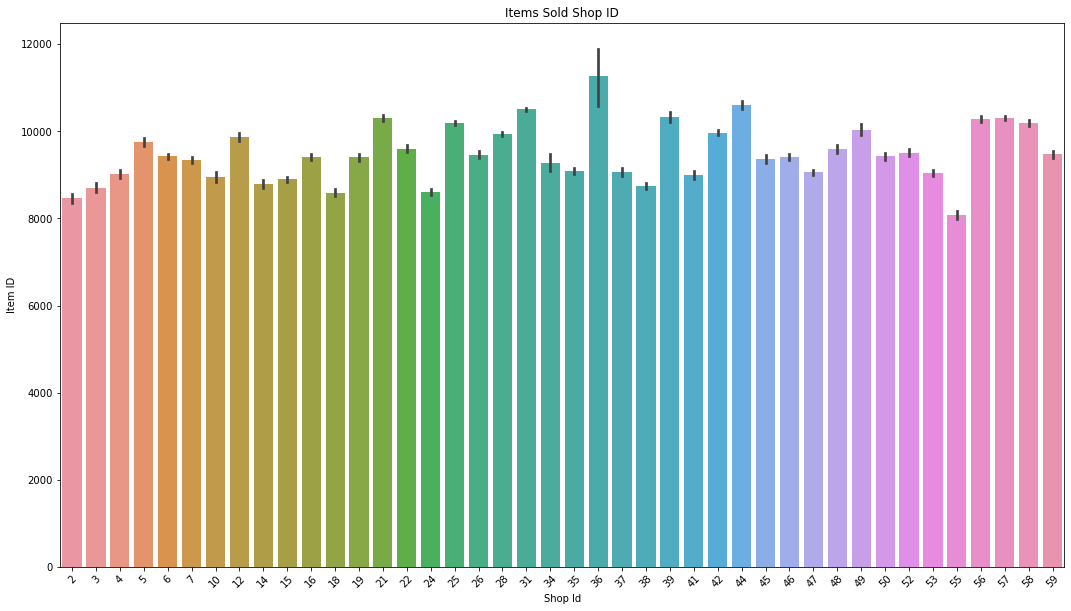

In [28]:
plt.figure(figsize = (18,10))
plt.title('Items Sold Shop ID')
ax = sns.barplot(x='shop_id', y="item_id", data=train, estimator=np.mean)
ax = ax.set(xlabel='Shop Id', ylabel='Item ID')
plt.xticks(rotation=45)
plt.show() 

In [29]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [30]:
cats['category']=cats['item_category_name'].str.split('-')
cats['type']=cats['category'].apply(lambda x: x[0].strip())
cats['sub_type'] = cats['category'].apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats.drop(['item_category_name','category'], inplace=True, axis=1)
cats.head()

,item_category_id,type,sub_type
0,0,PC,Гарнитуры/Наушники
1,1,Аксессуары,PS2
2,2,Аксессуары,PS3
3,3,Аксессуары,PS4
4,4,Аксессуары,PSP


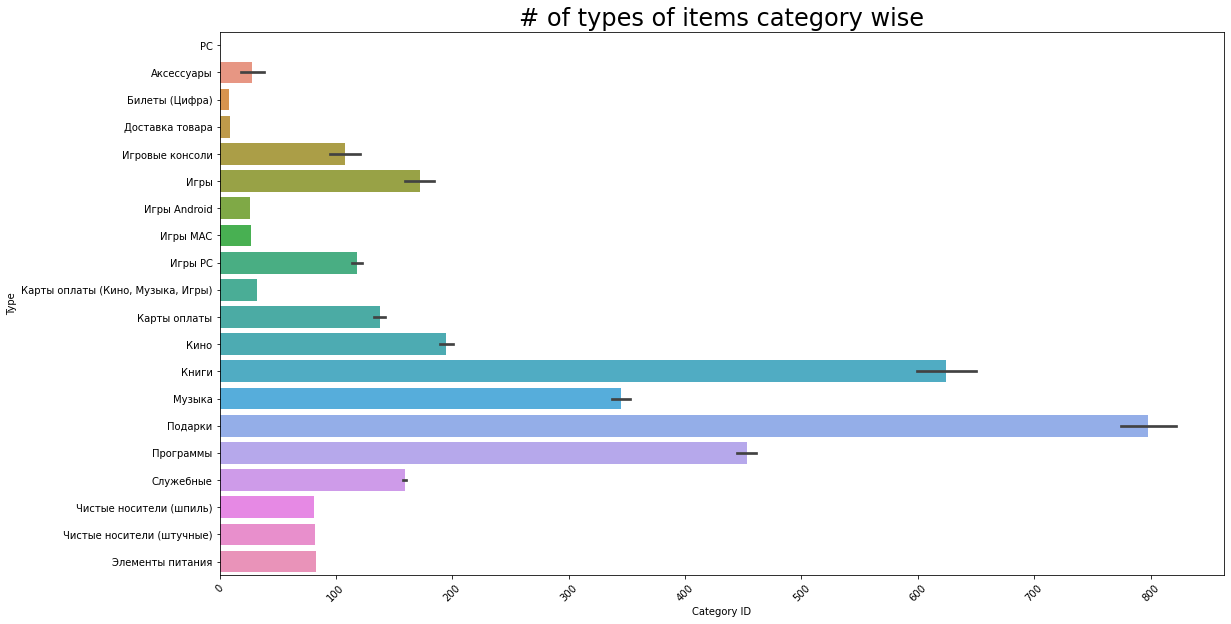

In [31]:
plt.figure(figsize = (18,10))
plt.title('# of types of items category wise', fontsize=24)
ax = sns.barplot(x='item_category_id', y='type', data=cats, estimator=np.sum)
ax = ax.set(xlabel='Category ID', ylabel='Type')
plt.xticks(rotation=45)

plt.show() 

## Feature 생성

In [32]:
train["date"][0]

'02.01.2013'

In [33]:
train.shape

(1221474, 6)

In [34]:
train["date"][0][:2]

'02'

In [35]:
train["date"].apply(lambda x: x[:2])

0          02
10         03
11         05
12         07
13         08
           ..
2935844    10
2935845    09
2935846    14
2935847    22
2935848    03
Name: date, Length: 1221474, dtype: object

In [36]:
train["day"] = train["date"].apply(lambda x: int(x[:2]))
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day
0,02.01.2013,0,59,22154,999.0,1.0,2
10,03.01.2013,0,25,2574,399.0,2.0,3
11,05.01.2013,0,25,2574,399.0,1.0,5
12,07.01.2013,0,25,2574,399.0,1.0,7
13,08.01.2013,0,25,2574,399.0,2.0,8


In [37]:
train["day"].describe()

count    1.221474e+06
mean     1.612353e+01
std      8.912680e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.600000e+01
75%      2.400000e+01
max      3.100000e+01
Name: day, dtype: float64

In [38]:
train["date"][0][3:5]

'01'

In [39]:
train["month"] = train["date"].apply(lambda x: int(x[3:5]))
train["month"].describe()

count    1.221474e+06
mean     6.629442e+00
std      3.469601e+00
min      1.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.000000e+01
max      1.200000e+01
Name: month, dtype: float64

In [40]:
train["year"] = train["date"].apply(lambda x: int(x[6:]))
train["year"].describe()

count    1.221474e+06
mean     2.014144e+03
std      7.685865e-01
min      2.013000e+03
25%      2.014000e+03
50%      2.014000e+03
75%      2.015000e+03
max      2.015000e+03
Name: year, dtype: float64

In [41]:
train.drop(columns = "date", inplace = True)
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,0,59,22154,999.0,1.0,2,1,2013
10,0,25,2574,399.0,2.0,3,1,2013
11,0,25,2574,399.0,1.0,5,1,2013
12,0,25,2574,399.0,1.0,7,1,2013
13,0,25,2574,399.0,2.0,8,1,2013


In [42]:
train.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=True)

In [43]:
#item_cnt_month = train.groupby(['item_id','shop_id','month']).sum()['item_cnt_day'].reset_index()
#item_cnt_month.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=True)
#item_cnt_month

In [44]:
#train=pd.merge(train,item_cnt_month,how='left',on=['item_id','shop_id','month'])
#del train['item_cnt_day']

In [45]:
test["year"] = 2015
test["month"] = 11
test.head()
del test['month']

In [46]:
test["date_block_num"] = 34
test.head()

,ID,shop_id,item_id,year,date_block_num
0,0,5,5037,2015,34
1,1,5,5320,2015,34
2,2,5,5233,2015,34
3,3,5,5232,2015,34
4,4,5,5268,2015,34


In [47]:
#test['date_block_num'] = test['date_block_num'].astype(np.int8)
#test['shop_id'] = test['shop_id'].astype(np.int8)
#test['item_id'] = test['item_id'].astype(np.int16)

In [48]:
train

,date_block_num,shop_id,item_id,item_price,item_cnt_month,day,month,year
0,0,59,22154,999.0,1.0,2,1,2013
10,0,25,2574,399.0,2.0,3,1,2013
11,0,25,2574,399.0,1.0,5,1,2013
12,0,25,2574,399.0,1.0,7,1,2013
13,0,25,2574,399.0,2.0,8,1,2013
...,...,...,...,...,...,...,...,...
2935844,33,25,7409,299.0,1.0,10,10,2015
2935845,33,25,7460,299.0,1.0,9,10,2015
2935846,33,25,7459,349.0,1.0,14,10,2015
2935847,33,25,7440,299.0,1.0,22,10,2015


In [49]:
test.head()

,ID,shop_id,item_id,year,date_block_num
0,0,5,5037,2015,34
1,1,5,5320,2015,34
2,2,5,5233,2015,34
3,3,5,5232,2015,34
4,4,5,5268,2015,34


In [50]:
all_data=pd.merge(train,test,on=['item_id','shop_id'],how='left')
all_data

,date_block_num_x,shop_id,item_id,item_price,item_cnt_month,day,month,year_x,ID,year_y,date_block_num_y
0,0,59,22154,999.0,1.0,2,1,2013,150983,2015,34
1,0,25,2574,399.0,2.0,3,1,2013,56520,2015,34
2,0,25,2574,399.0,1.0,5,1,2013,56520,2015,34
3,0,25,2574,399.0,1.0,7,1,2013,56520,2015,34
4,0,25,2574,399.0,2.0,8,1,2013,56520,2015,34
...,...,...,...,...,...,...,...,...,...,...,...
1221469,33,25,7409,299.0,1.0,10,10,2015,58431,2015,34
1221470,33,25,7460,299.0,1.0,9,10,2015,59331,2015,34
1221471,33,25,7459,349.0,1.0,14,10,2015,58430,2015,34
1221472,33,25,7440,299.0,1.0,22,10,2015,60342,2015,34


## Data 쪼개기

In [51]:
x_train=all_data[all_data['date_block_num_x']<33].drop(['item_cnt_month'],axis=1)
y_train=all_data[all_data['date_block_num_x']<33]['item_cnt_month']
x_valid=all_data[all_data['date_block_num_x']==33].drop(['item_cnt_month'],axis=1)
y_valid=all_data[all_data['date_block_num_x']==33]['item_cnt_month']
x_test=all_data[all_data['date_block_num_y']==34].drop(['item_cnt_month'],axis=1)

In [52]:
x_train

,date_block_num_x,shop_id,item_id,item_price,day,month,year_x,ID,year_y,date_block_num_y
0,0,59,22154,999.0,2,1,2013,150983,2015,34
1,0,25,2574,399.0,3,1,2013,56520,2015,34
2,0,25,2574,399.0,5,1,2013,56520,2015,34
3,0,25,2574,399.0,7,1,2013,56520,2015,34
4,0,25,2574,399.0,8,1,2013,56520,2015,34
...,...,...,...,...,...,...,...,...,...,...
1172064,32,25,21109,1799.0,29,9,2015,60899,2015,34
1172065,32,25,21109,1799.0,12,9,2015,60899,2015,34
1172066,32,25,21022,1799.0,27,9,2015,60261,2015,34
1172067,32,25,21105,1799.0,19,9,2015,59895,2015,34


In [53]:
y_train

0          1.0
1          2.0
2          1.0
3          1.0
4          2.0
          ... 
1172064    1.0
1172065    1.0
1172066    1.0
1172067    1.0
1172068    1.0
Name: item_cnt_month, Length: 1172069, dtype: float64

## Modeling

### xgboost

In [54]:
from xgboost import XGBRegressor


model_xgb = XGBRegressor(max_depth=8,n_estimators=1000,min_child_weight=300,colsample_bytree=0.8,subsample=0.8,eta=0.3,seed=42)

model_xgb.fit(x_train,y_train,eval_metric='rmse',
         eval_set=[(x_train,y_train),(x_valid,y_valid)],
         verbose=True, early_stopping_rounds=10)

[0]	validation_0-rmse:2.14794	validation_1-rmse:1.38084
[1]	validation_0-rmse:2.02451	validation_1-rmse:1.30948
[2]	validation_0-rmse:1.95814	validation_1-rmse:1.26799
[3]	validation_0-rmse:1.90859	validation_1-rmse:1.25411
[4]	validation_0-rmse:1.88400	validation_1-rmse:1.24482
[5]	validation_0-rmse:1.86417	validation_1-rmse:1.24101
[6]	validation_0-rmse:1.85267	validation_1-rmse:1.24071
[7]	validation_0-rmse:1.84037	validation_1-rmse:1.23964
[8]	validation_0-rmse:1.83469	validation_1-rmse:1.23945
[9]	validation_0-rmse:1.83155	validation_1-rmse:1.23990
[10]	validation_0-rmse:1.82347	validation_1-rmse:1.23702
[11]	validation_0-rmse:1.81991	validation_1-rmse:1.23737
[12]	validation_0-rmse:1.81150	validation_1-rmse:1.23577
[13]	validation_0-rmse:1.80528	validation_1-rmse:1.23919
[14]	validation_0-rmse:1.80243	validation_1-rmse:1.23829
[15]	validation_0-rmse:1.80015	validation_1-rmse:1.23942
[16]	validation_0-rmse:1.79442	validation_1-rmse:1.24022
[17]	validation_0-rmse:1.78670	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [82]:
pred_xgb = model_xgb.predict(x_test).clip(0., 20.)

# 제출 submission 생성
preds = pd.DataFrame(pred_xgb, columns=['item_cnt_month'])
preds.to_csv('submission_xgb.csv',index_label='ID')


In [83]:
preds = model_xgb.predict(x_test)
preds = x_test.assign(item_cnt_month=preds)
preds = preds[['ID', 'item_cnt_month']]
preds = preds.sort_values(by='ID')
preds

,ID,item_cnt_month
1107048,0,0.980814
1017292,0,0.939279
952349,0,0.952190
741819,0,1.077961
741818,0,1.111430
...,...,...
236264,214197,1.030689
526603,214199,1.040520
485724,214199,1.040520
479479,214199,1.048528


#### 수정,,,

In [ ]:
sub=pd.read_csv('submission_xgb.csv')
fin=sub[0:214200]
fin

fin.to_csv('submisiion_pile.csv',index=False)
fin

### Light GBM

In [57]:
from lightgbm import LGBMRegressor

model_lgb = LGBMRegressor( n_estimators=200,
                           learning_rate=0.03,
                           num_leaves=32,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           max_depth=8,
                           reg_alpha=0.04,
                           reg_lambda=0.073,
                           min_split_gain=0.0222415,
                           min_child_weight=40)

model_lgb.fit(x_train,y_train,eval_metric='rmse',
         eval_set=[(x_train,y_train),(x_valid,y_valid)],
         verbose=True, early_stopping_rounds=10)

y_pred_lgb = model_lgb.predict(x_test)

[1]	training's rmse: 2.1883	training's l2: 4.78867	valid_1's rmse: 1.38704	valid_1's l2: 1.92388
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 2.17251	training's l2: 4.71978	valid_1's rmse: 1.37803	valid_1's l2: 1.89896
[3]	training's rmse: 2.15751	training's l2: 4.65486	valid_1's rmse: 1.36959	valid_1's l2: 1.87577
[4]	training's rmse: 2.14315	training's l2: 4.59307	valid_1's rmse: 1.3628	valid_1's l2: 1.85722
[5]	training's rmse: 2.12979	training's l2: 4.53602	valid_1's rmse: 1.35662	valid_1's l2: 1.84041
[6]	training's rmse: 2.11667	training's l2: 4.48028	valid_1's rmse: 1.34932	valid_1's l2: 1.82068
[7]	training's rmse: 2.10415	training's l2: 4.42744	valid_1's rmse: 1.3441	valid_1's l2: 1.80661
[8]	training's rmse: 2.09222	training's l2: 4.37738	valid_1's rmse: 1.33793	valid_1's l2: 1.79006
[9]	training's rmse: 2.08085	training's l2: 4.32994	valid_1's rmse: 1.33306	valid_1's l2: 1.77704
[10]	training's rmse: 2.07003	training's l2: 4.28503	valid_1

[83]	training's rmse: 1.80557	training's l2: 3.2601	valid_1's rmse: 1.25163	valid_1's l2: 1.56657
[84]	training's rmse: 1.80497	training's l2: 3.25792	valid_1's rmse: 1.25132	valid_1's l2: 1.5658
[85]	training's rmse: 1.80382	training's l2: 3.25375	valid_1's rmse: 1.25152	valid_1's l2: 1.5663
[86]	training's rmse: 1.80333	training's l2: 3.25201	valid_1's rmse: 1.25115	valid_1's l2: 1.56538
[87]	training's rmse: 1.80126	training's l2: 3.24452	valid_1's rmse: 1.25112	valid_1's l2: 1.56531
[88]	training's rmse: 1.80053	training's l2: 3.24191	valid_1's rmse: 1.25058	valid_1's l2: 1.56395
[89]	training's rmse: 1.79926	training's l2: 3.23735	valid_1's rmse: 1.25059	valid_1's l2: 1.56398
[90]	training's rmse: 1.7973	training's l2: 3.2303	valid_1's rmse: 1.25059	valid_1's l2: 1.56398
[91]	training's rmse: 1.79658	training's l2: 3.22768	valid_1's rmse: 1.25043	valid_1's l2: 1.56359
[92]	training's rmse: 1.79597	training's l2: 3.22552	valid_1's rmse: 1.25031	valid_1's l2: 1.56329
[93]	training's

In [58]:
# 테스트 세트 예측 및 클립 값을 지정된 범위로 가져옴
y_pred_lgb = model_lgb.predict(x_test).clip(0., 20.)

# 제출 submission 생성
preds = pd.DataFrame(y_pred_lgb, columns=['item_cnt_month'])
preds.to_csv('submission_lgb.csv',index_label='ID')

In [59]:
preds = model_lgb.predict(x_test)
preds = x_test.assign(item_cnt_month=preds)
preds = preds[['ID', 'item_cnt_month']]
preds = preds.sort_values(by='ID')
preds

,ID,item_cnt_month
1107048,0,1.159519
1017292,0,1.159519
952349,0,1.179839
741819,0,1.234493
741818,0,1.234493
...,...,...
236264,214197,1.108948
526603,214199,1.166739
485724,214199,1.166739
479479,214199,1.167803


## gradient boost model

In [60]:
from scipy.sparse import hstack, vstack
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, normalize

In [61]:
gradient_boost = GradientBoostingRegressor(n_estimators=500)
gradient_boost.fit(x_train, y_train)
train_pred = gradient_boost.predict(x_train)
rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f"RMSE on training set: {rmse}")

RMSE on training set: 1.7374457323171757


In [86]:
test_pred = gradient_boost.predict(x_test)
test_pred = x_test.assign(item_cnt_month=test_pred)
test_pred = test_pred[['ID', 'item_cnt_month']]
test_pred = test_pred.sort_values(by='ID')
test_pred
sub2=test_pred[0:214200]
sub2.to_csv('submission_pile3.csv',index=False)
sub2

,ID,item_cnt_month
1107048,0,0.942729
1017292,0,0.913729
952349,0,1.094244
741819,0,1.104735
741818,0,1.102284
...,...,...
906275,42674,2.706335
551409,42674,1.415733
3455,42674,1.240142
551410,42674,1.411678


In [84]:
# Create the submission file and submit
test_preds = pd.DataFrame(test_pred, columns=['item_cnt_month'])
test_preds.to_csv('submission_gb.csv',index_label='ID')

sub2=pd.read_csv('submission_gb.csv')
fin2=sub2[0:214200]
fin2

fin2.to_csv('submisiion_pile2.csv',index=False)
fin2

,ID,item_cnt_month
0,1107048,0.942729
1,1017292,0.913729
2,952349,1.094244
3,741819,1.104735
4,741818,1.102284
...,...,...
214195,906275,2.706335
214196,551409,1.415733
214197,3455,1.240142
214198,551410,1.411678


In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
RFR = RandomForestRegressor(n_estimators = 100)
RFR.fit(x_train,y_train)

print('Train set mse:', mean_squared_error(y_train, RFR.predict(x_train)))
print('Test set mse:', mean_squared_error(y_valid, RFR.predict(x_valid)))
print('Test set score:', RFR.score(x_train,y_train))

Train set mse: 0.3429798608273063
Test set mse: 1.8789330755996352
Test set score: 0.9294458936906679


# 참고한 자료

### https://www.kaggle.com/santosh1974/predict-future-sales